In [1]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import numpy as np


In [2]:
import torch.utils.data as data
from PIL import Image
import os
import torch.nn as nn


class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

## MNIST to MNIST-M

## extracting dataset in /content/..

In [3]:
import tarfile

with tarfile.open('/content/mnist_m.tar.gz', "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

In [23]:
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('..', 'dataset', source_dataset_name)
target_image_root = os.path.join('..', 'content', target_dataset_name)
model_root = os.path.join('..', 'models')




cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

manual_seed = 2023
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load data

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset_source = datasets.MNIST(
    root='../dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')

dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

##SVHN to MNIST

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Transform for SVHN (source)
transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

# Transform for MNIST (target)
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST images to 32x32 to match SVHN format
    transforms.Grayscale(3),  # Convert MNIST images to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
batch_size=128
# Load SVHN dataset
source_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform_svhn)
dataloader_source = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)

# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
dataloader_target = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 182040794/182040794 [00:50<00:00, 3618629.66it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 253244836.17it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33224271.48it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67370234.25it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 4630658.43it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [24]:
for data in dataloader_target:
  print(data[0].shape)
  break

torch.Size([128, 3, 28, 28])


# New Section

In [26]:
import torch.nn as nn
from torch.autograd import Function

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout2d())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax())

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 4 * 4, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

In [6]:
import torch.nn as nn
from torch.autograd import Function

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class CNNModel(nn.Module):
    def __init__(self, input_channels=3, num_classes=10, domain_classes=2):
        super(CNNModel, self).__init__()

        # Feature extractor
        self.feature = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        # Class classifier
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 5 * 5, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout2d(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )

        # Domain classifier
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 5 * 5, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, domain_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input_data, alpha):
      feature = self.feature(input_data)

    # Calculate the size of the flattened features
      size = feature.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s

      feature = feature.view(-1, num_features)  # Automatically infer batch size
      reverse_feature = ReverseLayerF.apply(feature, alpha)
      class_output = self.class_classifier(feature)
      domain_output = self.domain_classifier(reverse_feature)

      return class_output, domain_output

In [31]:
import os
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ... (other necessary imports)

def test(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m', 'svhn']

    model_root = '/content/mnist_mnistm_model_epoch.pth'
    image_root = '/content/mnist_m'

    cuda = True
    cudnn.benchmark = True
    batch_size = 128
    image_size = 28
    alpha = 0

    """ Load Data """
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    transform_mnist = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize MNIST images to 32x32 to match SVHN format
        transforms.Grayscale(3),  # Convert MNIST images to 3 channels
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img_transform_source = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    img_transform_target = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])


    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')
        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
    elif dataset_name == 'svhn':
        transform_svhn = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
        ])
        dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
    else:  # MNIST
        #dataset = datasets.MNIST(root='./data', train=False, transform=transform_mnist)
        dataset = datasets.MNIST(root='./data', train=False, download=True,transform=img_transform_source)


    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    """ Evaluate Model """
    my_net = torch.load(model_root)
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    n_total = 0
    n_correct = 0

    with torch.no_grad():
        for data in dataloader:
            t_img, t_label = data
            if cuda:
                t_img = t_img.cuda()
                t_label = t_label.cuda()

            class_output, _ = my_net(input_data=t_img, alpha=alpha)
            pred = class_output.data.max(1, keepdim=True)[1]
            n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
            n_total += t_label.size(0)

    accu = n_correct.item() * 1.0 / n_total
    print(f'epoch: {epoch}, accuracy of the {dataset_name} dataset: {accu}')
    return accu


In [32]:
cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

manual_seed = 2023
random.seed(manual_seed)
torch.manual_seed(manual_seed)


my_net = CNNModel()
optimizer = optim.Adam(my_net.parameters(), lr=lr)

loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in my_net.parameters():
    p.requires_grad = True



In [33]:
source_acc=[]
target_acc=[]

for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    while i < len_dataloader:

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = next(data_source_iter)
        s_img, s_label = data_source

        my_net.zero_grad()
        batch_size = len(s_label)
        #print(batch_size)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()
            domain_label = domain_label.cuda()

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)
        #print(input_img.shape)
        #print(class_label.shape)

        class_output, domain_output = my_net(input_data=input_img, alpha=alpha)
        #print(class_output.shape)
        #print(domain_output.shape)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, domain_label)

        # training model using target data
        data_target = next(data_target_iter)
        t_img, _ = data_target

        batch_size = len(t_img)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        if cuda:
            t_img = t_img.cuda()
            input_img = input_img.cuda()
            domain_label = domain_label.cuda()

        input_img.resize_as_(t_img).copy_(t_img)

        _, domain_output = my_net(input_data=input_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err = err_t_domain + err_s_domain + err_s_label
        err.backward()
        optimizer.step()

        i += 1

    print('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' % (epoch, i, len_dataloader, err_s_label.cpu().data.numpy(), err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy()))

    torch.save(my_net, '/content/mnist_mnistm_model_epoch.pth')
    source=test('MNIST', epoch)
    source_acc.append(source)
    target=test('mnist_m', epoch)
    target_acc.append(target)
    x = test('svhn',epoch)



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 0, [iter: 461 / all 461], err_s_label: 0.137113, err_s_domain: 0.338311, err_t_domain: 0.313503
epoch: 0, accuracy of the MNIST dataset: 0.9757
epoch: 0, accuracy of the mnist_m dataset: 0.4589490056660371
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 0, accuracy of the svhn dataset: 0.25580055316533495
epoch: 1, [iter: 461 / all 461], err_s_label: 0.165002, err_s_domain: 0.388082, err_t_domain: 0.439147
epoch: 1, accuracy of the MNIST dataset: 0.9865
epoch: 1, accuracy of the mnist_m dataset: 0.4967225863792912
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 1, accuracy of the svhn dataset: 0.2632529194837124
epoch: 2, [iter: 461 / all 461], err_s_label: 0.116168, err_s_domain: 0.478806, err_t_domain: 0.559573
epoch: 2, accuracy of the MNIST dataset: 0.9869
epoch: 2, accuracy of the mnist_m dataset: 0.5782690812131985
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 2, accuracy of the svhn dataset: 0.2592578365089121
epoch: 3,

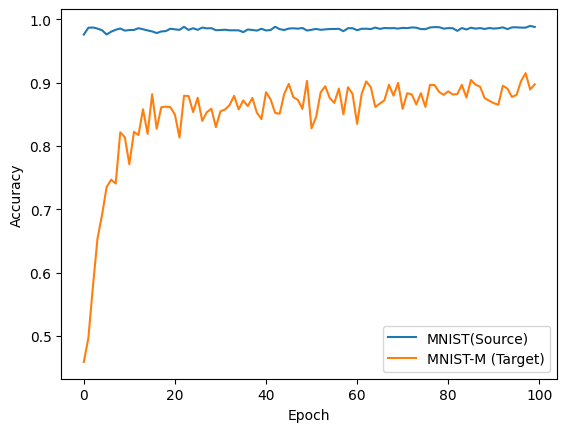

In [34]:
from matplotlib import pyplot as plt
plt.plot(source_acc, label='MNIST(Source)')
plt.plot(target_acc, label='MNIST-M (Target)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

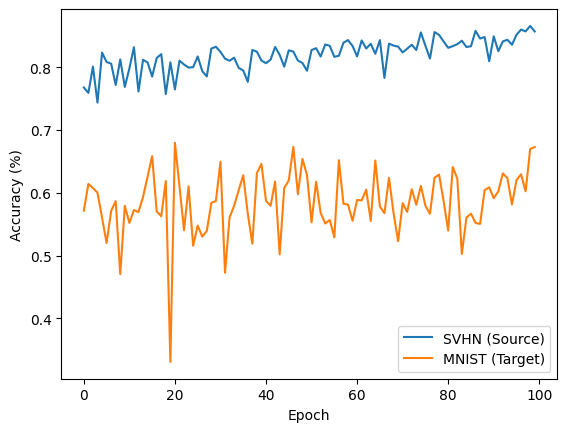

In [16]:
from matplotlib import pyplot as plt
plt.plot(source_acc, label='SVHN (Source)')
plt.plot(target_acc, label='MNIST (Target)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [7]:
import os
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ... (other necessary imports)

def test(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m', 'svhn']

    model_root = '/content/svhn_mnist_model_epoch.pth'
    image_root = '/content/mnist_m'

    cuda = True
    cudnn.benchmark = True
    batch_size = 128
    image_size = 32
    alpha = 0

    """ Load Data """
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    transform_mnist = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize MNIST images to 32x32 to match SVHN format
        transforms.Grayscale(3),  # Convert MNIST images to 3 channels
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img_transform_source = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    img_transform_target = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])


    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')
        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
    elif dataset_name == 'svhn':
        transform_svhn = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
        ])
        dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
    else:  # MNIST
        #dataset = datasets.MNIST(root='./data', train=False, transform=transform_mnist)
        dataset = datasets.MNIST(root='./data', train=False, download=True,transform=img_transform_source)


    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    """ Evaluate Model """
    my_net = torch.load(model_root)
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    n_total = 0
    n_correct = 0

    with torch.no_grad():
        for data in dataloader:
            t_img, t_label = data
            if cuda:
                t_img = t_img.cuda()
                t_label = t_label.cuda()

            class_output, _ = my_net(input_data=t_img, alpha=alpha)
            pred = class_output.data.max(1, keepdim=True)[1]
            n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
            n_total += t_label.size(0)

    accu = n_correct.item() * 1.0 / n_total
    print(f'epoch: {epoch}, accuracy of the {dataset_name} dataset: {accu}')
    return accu


In [9]:
test('mnist_m',1)

epoch: 1, accuracy of the mnist_m dataset: 0.42928563492945226


0.42928563492945226

## baseline model

In [1]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import numpy as np


In [2]:
import torch.utils.data as data
from PIL import Image
import os
import torch.nn as nn


class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [3]:
import tarfile

with tarfile.open('/content/mnist_m.tar.gz', "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

In [25]:
source_dataset_name = 'svhn'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('..', 'dataset', source_dataset_name)
target_image_root = os.path.join('..', 'content', target_dataset_name)
model_root = os.path.join('..', 'models')




cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 32
n_epoch = 100

manual_seed = 2023
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load data

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

#dataset_source = datasets.MNIST(
 #   root='../dataset',
 #   train=True,
 #   transform=img_transform_source,
 #   download=True
#)
transform_svhn = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)) ])
dataset_source = datasets.SVHN(
    root='../dataset',
    split='train',
    transform=transform_svhn,
    download=True
)
dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')

dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

100%|██████████| 182040794/182040794 [00:33<00:00, 5409284.00it/s]


In [26]:
for data in dataloader_source:
    imgs, labels = data
    print(imgs.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [12]:
import torch.nn as nn
from torch.autograd import Function

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class CNNModel(nn.Module):
    def __init__(self, input_channels=3, num_classes=10, domain_classes=2):
        super(CNNModel, self).__init__()

        # Feature extractor
        self.feature = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        # Class classifier
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 5 * 5, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout2d(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, input_data, alpha):
      feature = self.feature(input_data)

    # Calculate the size of the flattened features
      size = feature.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s

      feature = feature.view(-1, num_features)  # Automatically infer batch size
      class_output = self.class_classifier(feature)

      return class_output

In [27]:
import os
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ... (other necessary imports)

def test(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m', 'svhn']

    model_root = '/content/svhn_model_epoch.pth'
    image_root = '/content/mnist_m'

    cuda = True
    cudnn.benchmark = True
    batch_size = 128
    image_size = 32
    alpha = 0

    """ Load Data """
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    transform_mnist = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize MNIST images to 32x32 to match SVHN format
        transforms.Grayscale(3),  # Convert MNIST images to 3 channels
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img_transform_source = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    img_transform_target = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])


    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')
        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
    elif dataset_name == 'svhn':
        transform_svhn = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
        ])
        dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
    else:  # MNIST
        #dataset = datasets.MNIST(root='./data', train=False, transform=transform_mnist)
        dataset = datasets.MNIST(root='./data', train=False, download=True,transform=img_transform_source)


    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    """ Evaluate Model """
    my_net = torch.load(model_root)
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    n_total = 0
    n_correct = 0

    with torch.no_grad():
        for data in dataloader:
            t_img, t_label = data
            if cuda:
                t_img = t_img.cuda()
                t_label = t_label.cuda()

            class_output= my_net(input_data=t_img, alpha=alpha)
            pred = class_output.data.max(1, keepdim=True)[1]
            n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
            n_total += t_label.size(0)

    accu = n_correct.item() * 1.0 / n_total
    print(f'epoch: {epoch}, accuracy of the {dataset_name} dataset: {accu}')
    return accu


In [28]:
cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 32
n_epoch = 100

manual_seed = 2023
random.seed(manual_seed)
torch.manual_seed(manual_seed)


my_net = CNNModel()
optimizer = optim.Adam(my_net.parameters(), lr=lr)

loss_class = torch.nn.NLLLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()

for p in my_net.parameters():
    p.requires_grad = True



In [30]:
source_acc=[]
target_acc=[]

for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    while i < len_dataloader:

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = next(data_source_iter)
        s_img, s_label = data_source

        my_net.zero_grad()
        batch_size = len(s_label)
        #print(batch_size)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)
        #print(input_img.shape)
        #print(class_label.shape)

        class_output = my_net(input_data=input_img, alpha=alpha)
        #print(class_output.shape)
        #print(domain_output.shape)
        err_s_label = loss_class(class_output, class_label)

        # training model using target data

        err = err_s_label
        err.backward()
        optimizer.step()

        i += 1

    print('epoch: %d, [iter: %d / all %d], err_s_label: %f' % (epoch, i, len_dataloader, err_s_label.cpu().data.numpy()))

    torch.save(my_net, '/content/svhn_model_epoch.pth')
    source=test('MNIST', epoch)
    source_acc.append(source)
    target=test('mnist_m', epoch)
    target_acc.append(target)
    x = test('svhn',epoch)



epoch: 0, [iter: 461 / all 461], err_s_label: 0.804970
epoch: 0, accuracy of the MNIST dataset: 0.5518
epoch: 0, accuracy of the mnist_m dataset: 0.4001777580268859
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 0, accuracy of the svhn dataset: 0.8491087891825445
epoch: 1, [iter: 461 / all 461], err_s_label: 0.638288
epoch: 1, accuracy of the MNIST dataset: 0.5725
epoch: 1, accuracy of the mnist_m dataset: 0.40584379513387403
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 1, accuracy of the svhn dataset: 0.86240012292563
epoch: 2, [iter: 461 / all 461], err_s_label: 0.547519
epoch: 2, accuracy of the MNIST dataset: 0.5622
epoch: 2, accuracy of the mnist_m dataset: 0.4001777580268859
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 2, accuracy of the svhn dataset: 0.8709665027658267
epoch: 3, [iter: 461 / all 461], err_s_label: 0.548209
epoch: 3, accuracy of the MNIST dataset: 0.5722
epoch: 3, accuracy of the mnist_m dataset: 0.4172869

## SVHN trained prediction on mnist,mnist-m

In [31]:
test('MNIST',1)
test('mnist_m',2)
test('svhn',3)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1, accuracy of the MNIST dataset: 0.6806
epoch: 2, accuracy of the mnist_m dataset: 0.4801688701255416
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 3, accuracy of the svhn dataset: 0.9335817455439459


0.9335817455439459

## MNIST trained prediction on mnist-m,svhn

In [22]:
test('MNIST',1)
test('mnist_m',2)
test('svhn',3)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1, accuracy of the MNIST dataset: 0.9944
epoch: 2, accuracy of the mnist_m dataset: 0.4400622153094101
Using downloaded and verified file: ./data/test_32x32.mat
epoch: 3, accuracy of the svhn dataset: 0.23847572218807622


0.23847572218807622